# I - Bibliothèques et importation des données

## 1 - Bibliothèques

In [1]:
import pandas as pd
import numpy as np 
import networkx as nx
import sklearn
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import stats
from datetime import datetime
from statistics import mean
from networkx.algorithms import community
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

## 2 - Importation des données

In [2]:
#Importation des données
df = pd.read_csv('comments_students.csv')

In [10]:

#Suppression des colonnes doublons ou qui n'apportent pas d'informations pertinente
df = df.drop(['subreddit_id', 'subreddit'], axis = 1)


# II - Décomposition des colonnes en colonnes atomiques

> #### Link_ID

In [11]:
#On récupère la partie numérique des liens que l'on converti de la base 36 à la base 10

df['link_id'] = [int(df['link_id'][i][3:],36) for i in range(0,len(df['link_id']))]

In [21]:
#On identifie les posts commentés plus de n fois

n = 1000
d = dict(f['link_id'].value_counts())
df['link_id'] = [df['link_id'][i]
                   if (d[df['link_id'][i]] > n) 
                       else 'autre' 
                           for i in range(0,len(df['link_id']))]

In [42]:
#On binarise les valeurs de link_id

df = pd.concat([df,pd.get_dummies(df['link_id'])], axis = 1)


> #### Parent_ID

In [23]:
#On séparer les parent_id en fonction de s'il répondent au post de base ou à un commentaire

df['t1'] = [1 if df['parent_id'][i][:2] =='t1' else 0 for i in range(0,len(df['parent_id']))]

In [24]:
#On récupère la partie numérique des parent_id que l'on converti de la base 36 à la base 10

df['parent_id'] = [int(df['parent_id'][i][3:],36) for i in range(0,len(df['parent_id']))]

In [32]:
#On identifie les parent_id référencés plus de n fois

n = 1000
d = dict(df['parent_id'].value_counts())
df['parent_id'] = [df['parent_id'][i]
                   if (d[df['parent_id'][i]] > n) 
                       else 'autre' 
                           for i in range(0,len(df['parent_id']))]

In [40]:
#On binarise les valeurs de parent_id

df = pd.concat([df,pd.get_dummies(df['parent_id'])], axis = 1)

> #### Author

In [35]:
#On identifie les auteurs à l'origine de plus de n posts

n = 1000
d = dict(df['author'].value_counts())
df['author'] = [df['author'][i]
                   if (d[df['author'][i]] > n) 
                       else 'autre' 
                           for i in range(0,len(df['author']))]

In [180]:
#On binarise les valeurs de author

df = pd.concat([df,pd.get_dummies(df['author'])], axis = 1)


> #### Created_UTC

A noter que les created_utcs correspondent à une date précise (année, mois, jour, heure, minute, seconde)

In [44]:
#Ces fonctions déterminent le moment où a été publié le message

#Ici on détermine si le message a été écrit très tôt, dans la matinée, à midi, l'après-midi ou le soir
def periodeJour(utc) :
    transformation = datetime.utcfromtimestamp(utc)
    heure = transformation.hour
    if (heure >= 20 and heure <= 24) or (heure >=0 and heure <1) :
        return 'soir'
    elif (heure >= 1 and heure < 8) :
        return 'tot'
    elif (heure >= 8 and heure < 12) :
        return 'matin'
    elif (heure >= 12 and heure < 15) :
        return 'midi'
    else :
        return 'apres-midi'

#Ici on détermine si le message a été écrit en semaine ou en week-end
#Les jours 2,3,9,10,16,17,23,24,30,31 correspondent aux week-end du mois de mai 2015

def periodeMois(utc) :
    transformation = datetime.utcfromtimestamp(utc)
    jour = transformation.day
    if ( ((jour-2)%7 == 0) or ((jour-3)%7 == 0) ):
        return('week-end')
    else :
        return('semaine')

#Ici on détermine si le message a été écrit un jour férié ou non
#Les jours fériés en Amérique étaient le 10, 25, 26 mai 2015

def Ferie(utc) :
    transformation = datetime.utcfromtimestamp(utc)
    jour = transformation.day
    joursFeries = [10,25,26]
    if (jour in joursFeries) :
        return('férié')
    else : 
        return('pas férié')


In [47]:
#Ajout des colonnes periodeJour, periodeMois, jourFerie dans le dataframe avec les valeurs correspondantes
#pour chaque date UTC

df['periodeJour'] = [periodeJour(df['created_utc'][i]) for i in range(0,len(df))]
df['periodeMois'] = [periodeMois(df['created_utc'][i]) for i in range(0,len(df))]
df['jourFerie'] = [Ferie(df['created_utc'][i]) for i in range(0,len(df))]

In [95]:
#On binarise les valeurs de jourFerie, periodeJour et periodeMois

df = pd.concat([df,pd.get_dummies(df['jourFerie'])], axis = 1)
df = pd.concat([df,pd.get_dummies(df['periodeJour'])], axis = 1)
df = pd.concat([df,pd.get_dummies(df['periodeMois'])], axis = 1)


In [ ]:
#On binarise les valeurs de periodeJour

df = pd.concat([df,pd.get_dummies(df['periodeJour'])], axis = 1)


In [180]:
#On binarise les valeurs de periodeMois

df = pd.concat([df,pd.get_dummies(df['periodeMois'])], axis = 1)


#### On supprime les colonnes binarisées

In [43]:

df = df.drop(['link_id', 'author', 'parent_id','periodeMois','periodeJour','jourFerie'], axis = 1)


# III - Création de features à l'aide des réseaux de neurones

###  1- Premier réseau liant les parent_id à l'id du commentaire parent

In [226]:
g= nx.DiGraph()


In [227]:
g.add_nodes_from(df.id, type="link")
g.add_nodes_from(df.name, type="comment")

In [ ]:
g.add_edges_from(df[["name","parent_id"]].values, link_type="parent")

### 2 - Création du second réseau liant les auteurs entre eux

#### Remplacer les parent_id par l'auteur parent

In [91]:
#Ne pas lancer après code pour séparer les auteurs + de 1000 commentaires et autre

#On fait une jointure entre les parent_id et les name
df2 = df[['name','author']]
df3 = df['parent_id']
merge = pd.merge(df2, df3, left_on = ['name'], right_on = ['parent_id'])
merge

,name,author,parent_id
0,t1_cqug91e,dcblackbelt,t1_cqug91e
1,t1_cqug921,youthfulvictim,t1_cqug921
2,t1_cqug923,sonovadoyle,t1_cqug923
3,t1_cqug93u,bunnylumps,t1_cqug93u
4,t1_cqug93u,bunnylumps,t1_cqug93u
5,t1_cqug94d,SpareLiver,t1_cqug94d
6,t1_cqug94y,robondes,t1_cqug94y
7,t1_cqug94y,robondes,t1_cqug94y
8,t1_cqug95f,JustMe80,t1_cqug95f
9,t1_cqug966,wackawacka2,t1_cqug966


In [103]:
#pour regarde le nom des auteurs associés aux parent_id
dictionnaireId = dict()
for i in tqdm(range(0,len(merge))) :
    
    dictionnaireId[merge['parent_id'][i]] = merge['author'][i] 

100%|█████████████████████████████████████████████████████████████████████| 2510195/2510195 [03:20<00:00, 12499.09it/s]


In [104]:
#On récupère les id disctincs des auteurs
parents = [df['name'][i] for i in range(0,len(df))]
parents = set(parents)

In [110]:
#on parcourt les parent_id et on regarde ceux qui font référence à un auteur qu'on ne connait pas
pas = []

for i in tqdm(range(0,len(df))) :
    p= df['parent_id'][i]
    if p not in parents :
        pas.append(p)

100%|█████████████████████████████████████████████████████████████████████| 4234970/4234970 [03:11<00:00, 22089.35it/s]


In [111]:
#Dans notre dictionnaire, les parent_id ne referençant personne gardent leur nom de lien
for i in tqdm(range(0,len(pas))):
    dictionnaireId[pas[i]] = pas[i]

100%|███████████████████████████████████████████████████████████████████| 1724775/1724775 [00:01<00:00, 1291381.61it/s]


In [112]:
par = []
#on parcourt dataframe et chacun recup soit son pseudo_parent ou lui même
for i in tqdm(range(0,len(df))):
    pare = df['parent_id'][i]
    par.append(dictionnaireId[pare])
    

100%|█████████████████████████████████████████████████████████████████████| 4234970/4234970 [03:16<00:00, 21524.66it/s]


In [113]:
#On insère la nouvelle colonne dans le dataframe
df['pseudo_parent'] = par

In [128]:
#On retrouve dans pseudo parent le nom de l'auteur à qui on répond, sinon le parent_id reste inchangé
df.head()


,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id,pseudo_parent
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr,t1_cqug2sr
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry,t3_34fvry
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb,t1_cqu80zb
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m,t1_cqtdj4m
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc,t1_cquc4rc


In [183]:
#Remplacer les parent_id par le nom de l'auteur et mettre dans "non renseigné" si l'auteur n'est pas renseigné
parent_idbis = []
for i in tqdm(range(0,len(df))):
    parent = df['pseudo_parent'][i]
    if (parent[:2] =='t1') or (parent[:2] =='t3'):
        parent_idbis.append('non renseigne')
    else :
        parent_idbis.append(parent)

100%|█████████████████████████████████████████████████████████████████████| 4234970/4234970 [06:19<00:00, 11168.44it/s]


In [184]:
dfe['parent_idbis'] = parent_idbis

Second graphe liant les auteurs entre eux

In [185]:
g= nx.DiGraph()

In [186]:
g.add_nodes_from(dfe.author, type="link")
g.add_nodes_from(dfe.name, type="comment")

In [187]:
g.add_edges_from(dfe[["parent_idbis","author"]].values, link_type="parent")

## 1 - Centralité

In [50]:
katz = nx.katz_centrality(g)
katz = [katz[dfe['parent_id'][i]] for i in range(0,len(dfe))]
df['katz'] = katz

In [294]:
eigen = nx.eigenvector_centrality(g, max_iter=1000)
eigen = [eigen[dfe['parent_id'][i]] for i in range(0,len(dfe))]
df['eigen'] = eigen

In [ ]:
closeness = nx.closeness_centrality(g)
close = [closeness[dfe['parent_id'][i]] for i in range(0,len(dfe))]
df['closness'] = close

In [ ]:
degree = nx.degree_centrality(g)
degree = [degree[dfe['parent_id'][i]] for i in range(0,len(dfe))]
df['degree'] = degree

## 2 - Pretige

### PageRank

In [348]:
pagerank = nx.pagerank(g)
p = [pagerank[df['name'][i]] for i in range(0,len(df))]
df['pagerank'] = p

### Hits

In [7]:
H = nx.hits(g, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [16]:
hub = [H[0][df['name'][i]] for i in range(0,len(df))]
authorities = [H[1][df['name'][i]] for i in range(0,len(df))]

In [20]:
df['hub'] = hub
df['authorities'] = authorities

# IV - Création de features à partir d'analyses textuelles

## 1 - Nettoyage

In [173]:
def find_optimal_clusters(data, max_k):
    iters = [2,3,6,7,10,11,16,32]
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [145]:
def nettoyage(texte) :
    texte = texte.lower() #change le texte en minuscule

    texte = "".join([x if x.isalpha() else " " for x in texte]) #enlève les caractere speciaux + poncutations

    texte = " ".join(texte.split())
    return (texte)

In [146]:
#On applique la fonction de nettoyage à nos commentaires
txt = []
for i in tqdm(range(0,len(df))):
    txt.append(nettoyage(str(df['body'][i])))

100%|█████████████████████████████████████████████████████████████████████| 4234970/4234970 [05:46<00:00, 12213.79it/s]


In [147]:
df['bodynettoye'] = txt

In [149]:
#On enlève les mots vides des body

stp = stopwords.words('english')
motcles = []
for i in tqdm(range(0,len(df))):
    motcles.append([w for w in list(str(df['bodynettoye'][i]).split(' ')) if (not w in stp and w != ' ' and w !='')])

100%|██████████████████████████████████████████████████████████████████████| 4234970/4234970 [09:47<00:00, 7207.23it/s]


In [151]:
#On reforme les phrases

motcle = []
for e in tqdm(range(0,len(motcles))):
    element = motcles[e]
    phrase = ""
    for i in element :
        phrase+= " "+str(i)
    motcle.append(phrase[1:].lower())

100%|█████████████████████████████████████████████████████████████████████| 4234970/4234970 [00:49<00:00, 84985.28it/s]


In [153]:
#On crée une colonne avec seulement les "utiles" du body
df['mot cle'] = motcle

Nettoyage Lancaster

In [163]:
lancaster=LancasterStemmer()

mocl = []
for i in tqdm(range(0,len(motcle))) :
    mot = ""
    for elem in motcle[i].split(' '):
        mot+= " "+lancaster.stem(elem)
    mocl.append(mot)

100%|██████████████████████████████████████████████████████████████████████| 4234970/4234970 [19:08<00:00, 3688.02it/s]


In [165]:
df['lancaster_stem'] = mocl

TFIDF

In [167]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['lancaster_stem'])

Fit 2 clusters
Fit 3 clusters
Fit 6 clusters
Fit 7 clusters
Fit 10 clusters
Fit 11 clusters
Fit 16 clusters
Fit 32 clusters


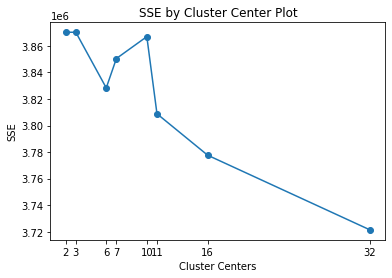

In [172]:
find_optimal_clusters(tfidf, 32)

In [184]:
clusters = MiniBatchKMeans(n_clusters=8, init_size = 1024, batch_size=2048,random_state=20).fit_predict(tfidf)

In [185]:
df['cluster8'] = clusters

In [186]:
df.groupby('cluster8')['ups'].mean()

cluster8
0    12.298974
1     3.946645
2    19.943966
3    16.412130
4     1.308163
5    15.674961
6    13.348829
7    12.445112
Name: ups, dtype: float64

In [187]:
df['cluster8'].value_counts()

7    2350211
3     641633
0     289295
1     284413
6     278277
5     272670
2      78110
4      40361
Name: cluster8, dtype: int64

In [190]:
df = pd.concat([df,pd.get_dummies(df['cluster8'])], axis = 1)

NMF

In [169]:
# ?NMF

In [192]:
nmf = NMF(n_components=15, random_state=1,
          alpha=.1, l1_ratio=.5,max_iter = 10).fit(tfidf)

In [193]:
nmf_features = nmf.transform(tfidf)

Fit 2 clusters
Fit 3 clusters
Fit 6 clusters
Fit 7 clusters
Fit 10 clusters
Fit 11 clusters
Fit 16 clusters
Fit 32 clusters


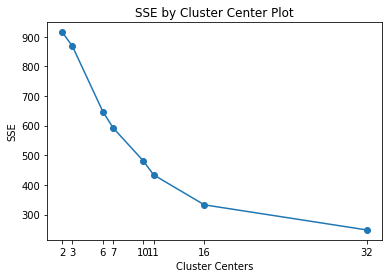

In [195]:
find_optimal_clusters(nmf_features, 20)

In [196]:
clusters = MiniBatchKMeans(n_clusters=16, init_size = 1024, batch_size=2048,random_state=20).fit_predict(nmf_features)


In [198]:
df['nmf'] = clusters

In [199]:
df.groupby('nmf')['ups'].mean()

nmf
0     13.155064
1      3.946596
2      1.462438
3      9.071591
4     13.208987
5     17.655637
6     15.136016
7     15.158667
8     13.910972
9      1.817887
10    14.785983
11    14.673029
12    11.126095
13     5.188356
14    11.564368
15    18.505596
Name: ups, dtype: float64

In [200]:
df['nmf'].value_counts()

0     2743088
1      284409
7      207494
10     195221
8      182805
4      166416
11     143947
15      91271
12      84468
5       36064
14      35739
2       34177
6        8603
3        7525
13       6937
9        6806
Name: nmf, dtype: int64

In [202]:
#la part d'implication de chaque mot dans les différent topic
components_df = pd.DataFrame(nmf.components_, columns=vectorizer.get_feature_names())

In [204]:
#On affiche les mots clés des différents topics, on décèlle des thèmes comme

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

In [214]:
lesTopics = pd.DataFrame(nmf_features, columns = ['topic 1','topic 2','topic 3','topic 4','topic 5','topic 6','topic 7',
                                      'topic 8','topic 9','topic 10','topic 11','topic 12','topic 13','topic 14',
                                      'topic 15'])

In [215]:
df = pd.concat([df,lesTopics], axis = 1)

On estime le sujet de chaque body

In [219]:
topicMax = []

for i in tqdm(range(0,len(pd.DataFrame(nmf_features)))):
    topicMax.append(df_nmf.loc[i].idxmax()+1)

100%|██████████████████████████████████████████████████████████████████████| 4234970/4234970 [14:07<00:00, 4998.38it/s]


In [220]:
df['sujetTraite'] = topicMax

Analyse de sentiments

In [158]:
sent = SentimentIntensityAnalyzer()
polarity = sent.polarity_scores
liste = []
body = df['bodynettoye']
for i in tqdm(range(0,len(body))):
    txt = str(body[i])
    liste.append(polarity(txt))
    

100%|██████████████████████████████████████████████████████████████████████| 4234970/4234970 [25:27<00:00, 2771.78it/s]


In [159]:
neg = []
neu = []
pos = []
compound = []
for i in tqdm(range(0,len(liste))) :
    neg.append(liste[i]['neg'])
    pos.append(liste[i]['pos'])
    neu.append(liste[i]['neu'])
    compound.append(liste[i]['compound'])

100%|████████████████████████████████████████████████████████████████████| 4234970/4234970 [00:04<00:00, 904105.67it/s]


In [160]:
df['negative'] = neg
df['positive'] = pos
df['neutral'] = neu
df['compound'] = compound

# V - Tests et prédiction du modèle

In [12]:
#On sépare la partie train et test de nos données
train = df[df['ups'].isna()==False]
test = df[df['ups'].isna()==True]

In [ ]:
Ytest = test['ups'].values
Xtest = test.drop(['ups'],axis=1)

Ytrain = train['ups'].values
Xtrain = train.drop(['ups'],axis=1)

## 1 - Test du modèle sur l'échantillon train

In [ ]:
#On effectue des sous test d'essai sur l'échantillon train
Xtrainbis, Xtestbis, Ytrainbis, Ytestbis = train_test_split(Xtrain, Ytrain, random_state=0,train_size = 2574810,test_size = 643702)

In [ ]:
#On récupère l'ensemble de nos parent_id, on enlève les doublons et les id référençant un
#auteur que l'on a pas
parents_id = list(set(df['parent_id']))
cequona = list(set(dictionnaireId.keys()))
difference = set(parents_id)-set(cequona)
for element in difference :
    dictionnaireId[element] = element

In [ ]:
#On s'entraine sur notre sous échantillon train et on teste la prédiction sur le
#sous échantillon test
reg = GradientBoostingRegressor(loss = 'lad',criterion = 'friedman_mse',max_features = 'sqrt',subsample = 0.8,alpha = 0.99,
                                n_estimators = 100)
reg.fit(pd.DataFrame(Xtrainbis[['degree','katz','eigen','closeness']]), Ytrainbis)

prediction = reg.predict(Xtestbis[['degree','katz','eigen','closeness']])

In [ ]:
#On estime l'erreur effectuée
meanerr = 0
moyenne = np.mean(prediction)
for i in range(0,len(prediction)):
    meanerr += abs(prediction[i] - Ytestbis[i])
print(meanerr/len(prediction))

## 2 - Prédiction des données

### a - Entrainement du modèle sur l'échantillon train

In [65]:
reg = GradientBoostingRegressor(loss = 'lad',criterion = 'mse',max_features = 'sqrt',subsample = 0.8,alpha = 0.99,n_estimators = 200)

reg.fit(Xtrain[['degree','katz','eigen','closeness','pagerank']], Ytrain)

### b - Prédiction

In [ ]:
prediction = reg.predict(Xtest[['degree','katz','eigen','closeness','pagerank']])

In [ ]:
evaluation = pd.DataFrame(test['id'])
evaluation['predicted'] = prediction
evaluation.to_csv("Prediction_9.csv",index = False)

### c - Deuxième analyse pour tenter d'ajuster les scores au dessus de 100

In [89]:
index = list()
for i in range(0,len(prediction)) :
    if prediction[i] >100:
        index.append(i)

In [206]:
#récupération des pos des Ytrainbis > 100
pos = []
for i in range(0,len(Ytrainbis)) :
    if Ytrainbis[i] >= 100:
        pos.append(i)

In [209]:
# 1 entrainement sur toute les données puis pred avec sgb
# 1 entrainement pour les prediction > 50 avec tree
# on regarde les pred > 50 on les entraine avec tree
X = pd.DataFrame(Xtrainbis).iloc[pos]
Y = pd.DataFrame(Ytrainbis).iloc[pos]
dtr = DecisionTreeClassifier()
X = pd.DataFrame(X[['degree','katz','eigen','closeness','pagerank']])

dtr.fit(X,Y)

In [216]:
posi = []
for i in range(0,len(prediction)):
    if prediction[i]> 50:
        posi.append(i)
len(posi)

9831

In [221]:
Xtestbis= Xtestbis.reset_index().drop('index',axis = 1)
Xprime = pd.DataFrame(Xtestbis).iloc[posi]
Xprime = pd.DataFrame(Xprime[['degree','katz','eigen','closeness','pagerank']])
predi = dtr.predict(Xprime)
p = prediction

In [241]:
i = 0
for element in posi:
    p[element] = (predi[i])
    i+=1

In [242]:
meanerr = 0
moyenne = np.mean(prediction)
for i in range(0,len(prediction)):
    meanerr += abs(p[i] - Ytestbis[i])
print(meanerr/len(prediction))

11.2841532574987
